In [1]:
import preprocess
import featureprocess
import fileio
import evaluation
import numpy as np
import modelacc
import pandas as pd
from sklearn.impute import SimpleImputer

In [2]:
dfoff,dftest,dfon = fileio.read_all()
dfoff,dfall,train,valid = preprocess.preprocess(dfoff)

In [3]:
def merge_nf2(df):
    """
    输入dftest或者dfoff,用于合并新特征1.
    新特征是使用dfoff的用户id计算的，所以对于其余df可能无法完全兼容，比如dftest会多两个id没有历史数据
    这里会用most填充
    """
    
    df.loc[:,'UM_id'] = df.User_id.astype('str')+'_'+df.Merchant_id.astype('str')
    dfnf2 = fileio.read_nf2()
    dfobj = pd.merge(df,dfnf2,'left',left_on='UM_id',right_on='用户id')
    
    #imp_most = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    #dfobj.iloc[:,-5::] = imp_most.fit_transform(dfobj.iloc[:,-5::])
    
    return dfobj

In [4]:
dfoff_1  = merge_nf2(dfoff)
dfall_1  = merge_nf2(dfall)

train_1  = merge_nf2(train)
valid_1  = merge_nf2(valid)
dftest_1 = merge_nf2(dftest)

In [18]:
dfoff_1[(dfoff_1.User_id == 1439408) & (dfoff_1.Merchant_id==2632)]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,UM_id,用户id,只领券,核销数,直接买,单商铺最大购买次数,成交商家数
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
5,1439408,2632,NaN,NaN,0.0,NaN,20160516.0,-1,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0


In [16]:
valid_1[(valid_1.User_id == 1439408) & (valid_1.Merchant_id==2632)]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,UM_id,用户id,只领券,核销数,直接买,单商铺最大购买次数,成交商家数
1,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
2,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0


In [10]:
dfnf2 = fileio.read_nf2()

In [14]:
df001 = dfnf2[dfnf2.用户id == '1439408_2632' ]

In [13]:
def user_features(df001):
    """返回userid，只领券，核销数，直接买，单商铺最大购买次数，成交商家数"""
    lcdict = {0:0,1:0,-1:0}
    #df001 = dfoff[dfoff.UM_id==uid]
    
    dflabelcount = df001.label.value_counts()
    dfMerchantcount = df001.Merchant_id.value_counts()
    for i in dflabelcount.index:
        lcdict[i] = dflabelcount[i]
    
    return [lcdict[0],lcdict[1],lcdict[-1],dfMerchantcount.max(),dfMerchantcount.count()]

In [ ]:
end

In [24]:
dfoff = featureprocess.process_features_main(dfoff)
dfall = featureprocess.process_features_main(dfall)

train = featureprocess.process_features_main(train)
valid = featureprocess.process_features_main(valid)
dftest = featureprocess.process_features_main(dftest)

In [31]:
def get_lastfeatures(manjian=True,weekdays=True,distance = True,people=True):
    
    
    lastfeatures = []
    weekdaycols = ['weekday_' + str(i) for i in range(1,8)]

    if manjian:
        lastfeatures = lastfeatures+ ['discount_rate','discount_type','discount_man', 'discount_jian']
    if weekdays:
        lastfeatures = lastfeatures+['weekday', 'weekday_type'] #+ weekdaycols
    if distance:
        lastfeatures = lastfeatures+['Distance']
    if people:
        #lastfeatures = lastfeatures+['只领券', '核销数', '直接买', '单商铺最大购买次数', '成交商家数']
        lastfeatures = lastfeatures+['核销数']
    
    if not len(lastfeatures):
        print('None features')
        return
    
    return lastfeatures

# 特征组合测试

In [5]:
##x_train,y_train,x_test,y_test = preprocess.split_xy(train,valid,columns=get_lastfeatures())
##
##model_name,model_score = modelacc.hodgepodge(modelacc.classifiers,x_train,y_train,x_test,y_test,valid)
##np.mean(model_score)
#
#combine_list = []
#def combine(a=None,b=None,combine_list=combine_list):
#    
#    if a == None:
#        a,b = '0','1'
#    
#    c,d = '0','1'
#    
#    a1 = a+c
#    a2 = a+d
#    a3 = b+c
#    a4 = b+d
#    
#    if len(a1) == 4:
#        combine_list = combine_list+[a1,a2,a3,a4]
#        return combine_list
#    
#    else:
#        combine_list = combine(a1,a2,combine_list)
#        combine_list = combine(a3,a4,combine_list)
#
#    return combine_list
#    
#ll = combine()
#combine_list = []
#for i in ll:
#    combine_list.append([True   if l == '0' else False for l in i  ])
#        
#
#feature_list = ['manjian','weekdays','distance','people']
#
#dfobj = pd.DataFrame(columns = ['均值','最小','最大','标准差'],index = ll)
#
#for l01 in ll:
#    i = [True   if l == '1' else False for l in l01  ]
#    if not True in i:
#        continue
#        
#    x_train,y_train,x_test,y_test = preprocess.split_xy(train,valid,columns=get_lastfeatures(manjian=i[0],
#                         #                                                                weekdays=i[1],distance = i[2],people=i[3]))
#    model_name,model_score = modelacc.hodgepodge(modelacc.classifiers,x_train,y_train,x_test,y_test,valid)
#    
#    print([feature_list[leng] for leng in range(0,len(i)) if i[leng] is True ])
#    dfobj.loc[l01,:] = [np.mean(model_score),np.max(model_score),np.min(model_score),np.std(model_score)]

# 关于修改nf2核销的测试

In [32]:
x_train,y_train,x_test,y_test = preprocess.split_xy(train,valid,columns=get_lastfeatures(manjian=0,
                                                                                     weekdays=0,distance = 1,people=1))

In [34]:
valid

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_rate,discount_man,...,weekday_5,weekday_6,weekday_7,UM_id,用户id,只领券,核销数,直接买,单商铺最大购买次数,成交商家数
0,1439408,4663,11002.0,150:20,1,20160528.0,NaN,0,0.866667,150,...,0,1,0,1439408_4663,NaN,1.0,0.0,0.0,1.0,1.0
1,1439408,2632,8591.0,20:1,0,20160613.0,NaN,0,0.950000,20,...,0,0,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
2,1439408,2632,8591.0,20:1,0,20160516.0,20160613.0,0,0.950000,20,...,0,0,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
3,2029232,450,1532.0,30:5,0,20160530.0,NaN,0,0.833333,30,...,0,0,0,2029232_450,NaN,1.0,0.0,0.0,1.0,1.0
4,2029232,6459,12737.0,20:1,0,20160519.0,NaN,0,0.950000,20,...,0,0,0,2029232_6459,NaN,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252581,118539,760,2418.0,30:5,0,20160606.0,NaN,0,0.833333,30,...,0,0,0,118539_760,NaN,1.0,0.0,0.0,1.0,1.0
252582,2876768,6901,2107.0,30:5,0,20160531.0,NaN,0,0.833333,30,...,0,0,0,2876768_6901,NaN,1.0,0.0,0.0,1.0,1.0
252583,4056416,2420,10883.0,100:30,2,20160613.0,NaN,0,0.700000,100,...,0,0,0,4056416_2420,NaN,1.0,0.0,0.0,1.0,1.0
252584,752472,7113,1633.0,50:10,6,20160613.0,NaN,0,0.800000,50,...,0,0,0,752472_7113,NaN,1.0,0.0,0.0,1.0,1.0


In [35]:
train

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_rate,discount_man,...,weekday_5,weekday_6,weekday_7,UM_id,用户id,只领券,核销数,直接买,单商铺最大购买次数,成交商家数
0,1439408,2632,8591.0,20:1,0,20160217.0,NaN,0,0.950000,20,...,0,0,0,1439408_2632,1439408_2632,2,0,0,2,1
1,1439408,2632,1078.0,20:1,0,20160319.0,NaN,0,0.950000,20,...,0,1,0,1439408_2632,1439408_2632,2,0,0,2,1
2,1832624,3381,7610.0,200:20,0,20160429.0,NaN,0,0.900000,200,...,1,0,0,1832624_3381,1832624_3381,1,0,0,1,1
3,2029232,3381,11951.0,200:20,1,20160129.0,NaN,0,0.900000,200,...,1,0,0,2029232_3381,2029232_3381,1,0,0,1,1
4,2223968,3381,9776.0,10:5,2,20160129.0,NaN,0,0.500000,10,...,1,0,0,2223968_3381,2223968_3381,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800691,212662,2934,5686.0,30:5,2,20160321.0,20160330.0,1,0.833333,30,...,0,0,0,212662_2934,212662_2934,0,2,0,2,1
800692,212662,3532,5267.0,30:5,1,20160322.0,NaN,0,0.833333,30,...,0,0,0,212662_3532,212662_3532,1,0,0,1,1
800693,212662,3021,3739.0,30:1,6,20160504.0,20160508.0,1,0.966667,30,...,0,0,0,212662_3021,212662_3021,1,1,0,2,1
800694,212662,2934,5686.0,30:5,2,20160321.0,20160322.0,1,0.833333,30,...,0,0,0,212662_2934,212662_2934,0,2,0,2,1


In [36]:
dftest

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,discount_rate,discount_man,discount_jian,discount_type,...,weekday_5,weekday_6,weekday_7,UM_id,用户id,只领券,核销数,直接买,单商铺最大购买次数,成交商家数
0,4129537,450,9983,30:5,1,20160712,0.833333,30,5,1,...,0,0,0,4129537_450,NaN,1.0,0.0,0.0,1.0,1.0
1,6949378,1300,3429,30:5,2,20160706,0.833333,30,5,1,...,0,0,0,6949378_1300,NaN,1.0,0.0,0.0,1.0,1.0
2,2166529,7113,6928,200:20,5,20160727,0.900000,200,20,1,...,0,0,0,2166529_7113,NaN,1.0,0.0,0.0,1.0,1.0
3,2166529,7113,1808,100:10,5,20160727,0.900000,100,10,1,...,0,0,0,2166529_7113,NaN,1.0,0.0,0.0,1.0,1.0
4,6172162,7605,6500,30:1,2,20160708,0.966667,30,1,1,...,1,0,0,6172162_7605,NaN,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113635,5828093,5717,10418,30:5,10,20160716,0.833333,30,5,1,...,0,1,0,5828093_5717,NaN,1.0,0.0,0.0,1.0,1.0
113636,6626813,1699,7595,30:1,2,20160707,0.966667,30,1,1,...,0,0,0,6626813_1699,NaN,1.0,0.0,0.0,1.0,1.0
113637,6626813,7321,7590,50:5,2,20160712,0.900000,50,5,1,...,0,0,0,6626813_7321,NaN,1.0,0.0,0.0,1.0,1.0
113638,4547069,760,13602,30:5,0,20160717,0.833333,30,5,1,...,0,0,1,4547069_760,4547069_760,1.0,0.0,0.0,1.0,1.0


# 关于修改label的测试
效果不咋地

In [44]:
# UM特征的单测试
x_train,y_train,x_test,y_test = preprocess.split_xy(train,valid,columns=get_lastfeatures(manjian=0,
                                                                                     weekdays=0,distance = 1,people=1))
model_name,model_score = modelacc.hodgepodge(modelacc.classifiers,x_train,y_train,x_test,y_test,valid)

#print([feature_list[leng] for leng in range(0,len(i)) if i[leng] is True ])
#dfobj.loc[l01,:] = [np.mean(model_score),np.max(model_score),np.min(model_score),np.std(model_score)]

In [10]:
dftest.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'discount_rate', 'discount_man', 'discount_jian',
       'discount_type', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'UM_id', '用户id', '只领券', '核销数', '直接买', '单商铺最大购买次数', '成交商家数'],
      dtype='object')

# 提交

In [6]:
def output_submit(model_this,original_feature):
    final_model = model_this
    y_test_pred = model_this.predict_proba(dftest[original_feature])
    dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
    dftest1['label'] = y_test_pred[:,1]
    #dftest1.to_csv(name, index=False, header=False)
    return dftest1

def count_fenshu(model,x_train,y_train,x_test,y_test,valid):
    model.fit(x_train, y_train)
    y_pre = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    cc = evaluation.get_official_auc(y_prob[:,1],y_test,valid)
    return cc,model

In [11]:
model_lr = modelacc.classifiers[0][1]
model_nbays = modelacc.classifiers[7][1]
model_lda = modelacc.classifiers[8][1]
model_mlp = modelacc.classifiers[9][1]

x_train,y_train,x_test,y_test = preprocess.split_xy(train,valid,columns=get_lastfeatures(manjian=0,
                                                                                     weekdays=0,distance = 1,people=1))

In [12]:
model_name = ['lr','bays','lda','mlp']
model_list = [model_lr,model_nbays,model_lda,model_mlp]

In [13]:
model_score = []
model_fited = []
for model in model_list:
    score_,model_ = count_fenshu(model,x_train,y_train,x_test,y_test,valid)
    model_score.append(score_)
    model_fited.append(model_)
    

In [14]:
dfsub_list = []
for model in model_fited:
    dfsub_list.append(output_submit(model,x_train.columns))

In [15]:
def toupiao(dfsub_list):
    label_list = []
    for i in dfsub_list:
        label_list.append(i.label)
    dftp = pd.DataFrame(label_list).T    
    dftp.loc[:,'max'] = dftp.max(axis=1) 
    dftp.loc[:,'min'] = dftp.min(axis=1) 
    dftp.loc[:,'mean'] = dftp.mean(axis=1) 
    
    dfdiji = dfsub_list[0].loc[:,['User_id','Coupon_id', 'Date_received']]
    dftest_max = pd.concat([dfdiji,dftp.loc[:,'max']],axis=1) 
    dftest_min = pd.concat([dfdiji,dftp.loc[:,'min']],axis=1) 
    dftest_mean = pd.concat([dfdiji,dftp.loc[:,'mean']],axis=1)
    return dftest_max,dftest_min,dftest_mean

In [16]:
dftest_max,dftest_min,dftest_mean = toupiao(dfsub_list)

In [23]:
## 增加
#dftest_max.loc[:,'max'].value_counts().sort_index()
#
#
#
#dftest_max_ts1 = dftest_max.copy()
#dftest_max_ts1.loc[:,'max'][dftest_max.loc[:,'max']>0.5]=0.99
#
#dftest_max_ts1.to_csv('../storage/20201025_mxts1.csv',header=False,index=False)

0.004856    10281
0.005807     1152
0.006943     1344
0.008298     1676
0.009916     2169
0.011846     2968
0.014146     3966
0.016885     5881
0.020143    21210
0.024014    18265
0.028608    41519
0.417780       48
0.428728        9
0.439746       11
0.450824        2
0.461951        6
0.473116        6
0.484308       20
0.495515       41
0.506727      229
0.517933      130
0.529120     1169
0.735647       12
0.735764       56
0.735881        4
0.735997        3
0.736114        2
0.736230        1
0.736347        7
0.772901        5
0.836392       66
0.867644       35
0.877692      424
0.923846        4
0.999502        2
0.999900        3
0.999943        7
0.999962       19
0.999970       13
0.999973      207
1.000000        1
1.000000       23
1.000000        9
1.000000      136
1.000000        4
1.000000        2
1.000000      493
Name: max, dtype: int64

In [135]:
for i in zip([dftest_max,dftest_min,dftest_mean],['max','min','mean']):
    i[0].to_csv('../storage/20201021'+i[1]+'.csv', index=False, header=False)

# 绘图区

In [11]:
# 
model_lr = modelacc.classifiers[0][1]

#original_feature = ['discount_rate','discount_type','discount_man', 'discount_jian','Distance', 'weekday', 'weekday_type'] + weekdaycols
original_feature = x_train.columns
final_model = model_lr
y_test_pred = final_model.predict_proba(dftest[original_feature])
dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
dftest1['label'] = y_test_pred[:,1]
dftest1.to_csv('submit_xgb.csv', index=False, header=False)
dftest1.head()

In [17]:
import matplotlib.pyplot as plt

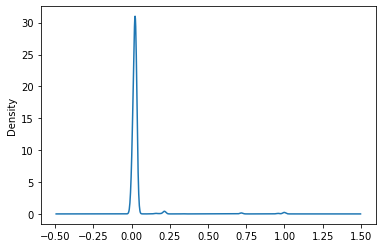

In [22]:
dftest1.label.plot(kind = 'kde')

In [25]:
dftest1.label

0         0.024014
1         0.020143
2         0.011846
3         0.011846
4         0.020143
            ...   
113635    0.004856
113636    0.020143
113637    0.020143
113638    0.028608
113639    0.011846
Name: label, Length: 113640, dtype: float64